<a href="https://colab.research.google.com/github/ddeMoivre/blog/blob/master/2022_02_09_Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bird spaces classification
> In this project we will use fastai package to classify bird spaces.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/goldfinch.jpg

In [16]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb  7 16:45:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    35W / 250W |   4207MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [19]:
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [20]:
#!kaggle datasets download -d gpiosenka/100-bird-species

In [21]:
#!unzip \*.zip  && rm *.zip

In [22]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [23]:

import torch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision.all import *
#from nbdev.showdoc import *

set_seed(2)
%matplotlib inline

In [24]:
path = Path('/content/drive/MyDrive/Kaggle')

In [25]:
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [26]:
# Generic container to quickly build Datasets and DataLoaders
birds = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=parent_label,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = birds.dataloaders(path, valid_pct=0.2)

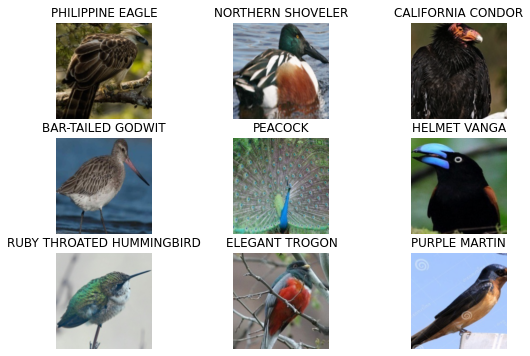

In [27]:
dls.show_batch(max_n=9, figsize=(9,6))

In [28]:
print(dls.vocab)
len(dls.vocab),dls.c

['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'ANHINGA', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ARARIPE MANAKIN', 'ASIAN CRESTED IBIS', 'BALD EAGLE', 'BALD IBIS', 'BALI STARLING', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BANDED BROADBILL', 'BANDED PITA', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BAY-BREASTED WARBLER', 'BEARDED BARBET', 'BEARDED BELLBIRD', 'BEARDED REEDLING', 'BELTED KINGFISHER', 'BIRD OF PARADISE', 'BLACK & YELLOW bROADBILL', 'BLACK BAZA', 'BLACK FRANCOLIN', 'BLACK SKIMMER', 'BLACK SWAN', 'BLACK TAIL CRAKE', 'BLACK THROATED BUSHTIT', 'BLACK THROATED WARBLER', 'BLACK VULTURE', 'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE', 'BLACK-THROATED SPARROW', 'BLACKBURNIAM WARBLER', 'BLONDE CRESTED WOODPECKER', 'BLUE COAU', 'BLUE GROUSE', 'BLUE HERON', 'BLUE THROATED TOUCANET', 'BOBOLINK', 'BO

(326, 326)

<> shows the difference between an image that has been zoomed, interpolated, rotated, and then interpolated again (which is the approach used by all other deep learning libraries), shown here on the right, and an image that has been zoomed and rotated as one operation and then interpolated just once on the left (the fastai approach), shown here on the left.

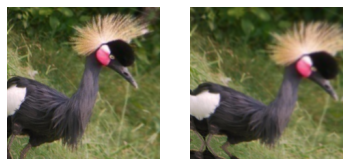

In [29]:
#hide_input
#id interpolations
#caption A comparison of fastai's data augmentation strategy (left) and the traditional approach (right).
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images to test'/'3.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Training: resnet34

In [30]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.281556,0.585761,0.146585,03:51


epoch,train_loss,valid_loss,error_rate,time
0,0.611539,0.314773,0.080854,03:56
1,0.308219,0.205119,0.050114,03:54


In [31]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Improving our model

SuggestedLRs(valley=0.003311311127617955)

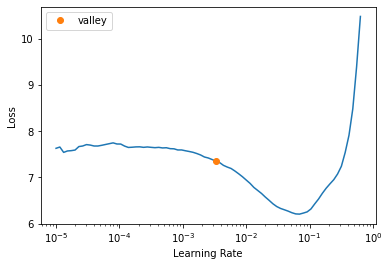

In [32]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.lr_find(start_lr=1e-5, end_lr=1e1)

In [33]:
learn.fine_tune??

In [34]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.091636,0.601378,0.163981,03:48
1,0.630284,0.308223,0.079371,03:49
2,0.422914,0.247530,0.061184,03:47


In [35]:
learn.unfreeze()

SuggestedLRs(valley=7.585775892948732e-05)

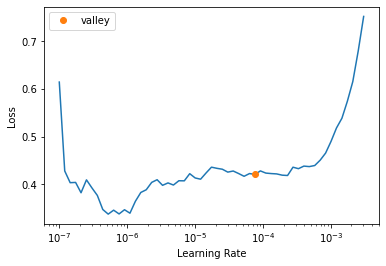

In [36]:
learn.lr_find()

In [37]:
learn.fit_one_cycle(10, lr_max=9e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.366718,0.241547,0.060986,03:55
1,0.392569,0.264818,0.068202,03:57
2,0.382351,0.240760,0.061085,03:54
3,0.280636,0.220931,0.055056,03:55
4,0.223109,0.198764,0.047346,03:54
5,0.156686,0.174471,0.040130,03:54
6,0.125461,0.163392,0.039439,03:54
7,0.095606,0.158930,0.036276,03:54
8,0.066164,0.154093,0.034200,03:54
9,0.055492,0.152054,0.034398,03:54


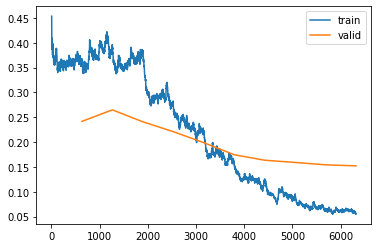

In [38]:
learn.recorder.plot_loss()